In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import blackhc.laaos


In [27]:
from pathlib import Path

# Get the current file's directory
current_working_directory = Path.cwd()

# Get the parent directory
parent_path = current_working_directory.parent

# Get the data-out directory
data_out_path = parent_path.joinpath('data-out', 'CIFAR10')

## Retrieve the results 

### CIFAR10 (Preactivation-Resnet)

At each acquisition, we acquire a new set of hyperparameters $\xi_t$, with which we train a model $f_{\hat{\theta}_t}$ with parameters $\hat{\theta}_t:=\hat{\theta}_t(\xi_t)$ on the training data $\mathcal{D}_{\mathrm{train}}$. We then evaluate its performance on the training data, the mean negative log likelihood loss $L_t\big(\hat{\theta}_{t};\,\mathcal{D}_{\mathrm{train}}\big)$. 

Given all $t$ models, we can get the model with best training performance: 
$$i_t^\ast = \arg\min_{1\le i\le t} L_i\big(\hat{\theta}_{i};\,\mathcal{D}_{\mathrm{train}}\big)$$ 
We then use the corresponding trained model $f_{\hat{\theta}_{i^\ast}}$ with $\hat{\theta}_{i^\ast}:=\hat{\theta}_{i^\ast}(\xi_{i^\ast})$ to predict on the target data $\mathcal{D}_{\mathrm{targt}}$ and obtain the target prediction loss 
$$u_t=L_{i^\ast}\big(\hat{\theta}_{i^\ast};\,\mathcal{D}_{\mathrm{targt}}\big).$$ 

Plot $u_t$ as a function of $t$.

In [45]:
import glob 


output_files = [] 

 
pattern = str(data_out_path.joinpath(data_out_path, '*.py'))  
for filename in glob.glob(pattern):
    output_files.append(filename)

len(output_files)

19

In [55]:
column_names = ["dataset", "var", "acquisition_method", "trial"]
df = pd.DataFrame(columns = column_names)

for filename in output_files:
    file_split = filename.split('/')[-1].split('_')
    dataset = file_split[0]
    acquisition_method = file_split[-1].split('.')[0]
    trial = int(file_split[-2][5:])
    var = float(file_split[2][3:])
    file_saved = blackhc.laaos.safe_load(filename) 
    single_output=[]
    if 'iterations' in file_saved:
        for item in file_saved['iterations']:
            single_output.append([item['tol']])
        tol_dct = dict(zip(iter(range(1,len(single_output)+1)), single_output))
        single_df = pd.DataFrame({'dataset': dataset, 'var': var, 
                                  'acquisition_method': acquisition_method, 
                                  'trial':trial,  **tol_dct})
        df = pd.concat([df, single_df], ignore_index = True)
       

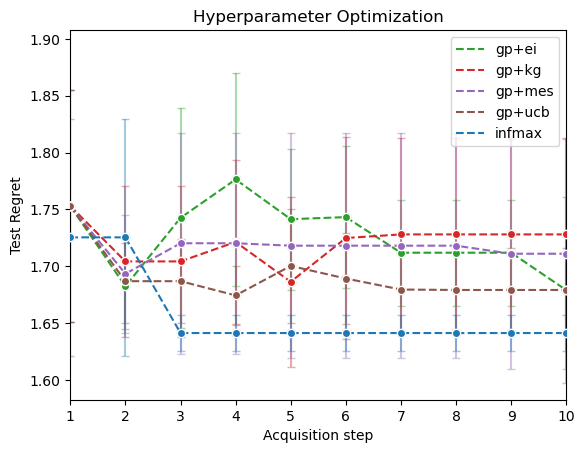

In [56]:
othermethods =['gp+ei', 'gp+kg', 'gp+mes', 'gp+ucb']  

color_pool = ['C'+str(i) for i in range(2+len(othermethods))]

dataset ='CIFAR10-preactrn'  
var = 0
 
for j, method in enumerate(othermethods):
     
    df_inv = df.loc[(df['dataset'] == dataset) & (df['acquisition_method'] == method) & (df['var']==var) ]
    out_inv = df_inv.dropna(axis=1).drop(columns=['dataset','acquisition_method','trial','var']).to_numpy()
    x = np.arange(1,out_inv.shape[-1]+1)
    out_inv = np.abs(out_inv) 
    y = out_inv.mean(0)
    e = out_inv.std(0) # 2*sigma ~ 95% confidence region
    plt.plot(x, y, '--', color=color_pool[2+j], label=method) 
    plt.errorbar(x, y, yerr=[e, e], fmt='o', color=color_pool[2+j], ecolor=color_pool[2+j], capsize=3, # capthick=0.2, 
             alpha=0.4)
    plt.scatter(x, y, color=color_pool[2+j], edgecolor='w', zorder=5) # alpha=0.5
   


df_inv = df.loc[(df['dataset'] == dataset) & (df['acquisition_method'] == 'infmax') & (df['var']==var)]
out_inv = df_inv.dropna(axis=1).drop(columns=['dataset','acquisition_method','trial','var']).to_numpy()
out_inv = np.abs(out_inv)
x = np.arange(1,out_inv.shape[-1]+1)
y = out_inv.mean(0)
e = out_inv.std(0) # 2*sigma ~ 95% confidence region
plt.plot(x, y, '--',  color=color_pool[0], label='infmax')
plt.scatter(x, y, color=color_pool[0], edgecolor='w', zorder=5) # edgecolor='w',alpha=0.5

plt.errorbar(x, y, yerr=[e, e], 
             fmt='o', 
             color=color_pool[0], 
             ecolor=color_pool[0], 
             capsize=3,
             # capthick=0.2, 
             alpha=0.4)
    

xlim_upper = 10
xlim_lower = 1   
plt.xlabel('Acquisition step')
plt.ylabel('Test Regret')
plt.xlim([xlim_lower, xlim_upper]) 
plt.title(f"Hyperparameter Optimization")
plt.legend()
plt.savefig(os.path.join('/Users/weichiyao/Desktop/',  f"HPO_{dataset}.pdf") )


#### ORACLE 
This gives the results if we know the oracle, i.e., at each acquisition (we have a new model trained with this set of new hyperparameters), we evaluate the target loss and note down the lowest target loss among all acquisitions 
$$v_t = \arg\min_{1\le i\le t} L_i(\hat{\theta}_i; \,\mathcal{D}_{\mathrm{targt}}),\quad\hat{\theta}_i:=\hat{\theta}_i(\xi_i).$$

Plot $v_t$ as a function of $t$. 


In [48]:
Oracle=True
if Oracle:
    column_names = ["dataset", "var", "acquisition_method", "trial"]
    df = pd.DataFrame(columns = column_names)
    for filename in output_files:
        file_split = filename.split('/')[-1].split('_')
        dataset = file_split[0]
        acquisition_method = file_split[-1].split('.')[0]
        trial = int(file_split[-2][5:])
        var = float(file_split[2][3:])
        file_saved = blackhc.laaos.safe_load(filename) 
        single_output=[[min(file_saved['initial_samples']['init_y_targt'])]]
        
        if 'iterations' in file_saved:
            for item in file_saved['iterations']:
                curr_min = min(single_output)[0]
                if isinstance(item['y_targt_chosen_samples'], list): 
                    to_eval = item['y_targt_chosen_samples'][0]
                else:
                    to_eval = item['y_targt_chosen_samples']
                if to_eval < curr_min:
                    single_output.append([to_eval])
                else:
                    single_output.append([curr_min])
            tol_dct = dict(zip(iter(range(1,len(single_output)+1)), single_output))
            single_df = pd.DataFrame({'dataset': dataset, 'var': var, 
                                      'acquisition_method': acquisition_method, 
                                      'trial':trial,  **tol_dct})
            df = pd.concat([df, single_df], ignore_index = True)

In [ ]:
othermethods =['gp+ei', 'gp+kg', 'gp+mes', 'gp+ucb']  

color_pool = ['C'+str(i) for i in range(2+len(othermethods))]

dataset ='CIFAR10-preactrn'  
var = 0
 
for j, method in enumerate(othermethods):
     
    df_inv = df.loc[(df['dataset'] == dataset) & (df['acquisition_method'] == method) & (df['var']==var) ]
    out_inv = df_inv.dropna(axis=1).drop(columns=['dataset','acquisition_method','trial','var']).to_numpy()
    x = np.arange(1,out_inv.shape[-1]+1)
    out_inv = np.abs(out_inv) 
    y = out_inv.mean(0)
    e = out_inv.std(0) # 2*sigma ~ 95% confidence region
    plt.plot(x, y, '--', color=color_pool[2+j], label=method) 
    plt.errorbar(x, y, yerr=[e, e], 
                 fmt='o', 
                 color=color_pool[2+j], 
                 ecolor=color_pool[2+j], 
                 capsize=3, 
                 # capthick=0.2, 
                 alpha=0.4)
    plt.scatter(x, y, color=color_pool[2+j], edgecolor='w', zorder=5) # alpha=0.5
   


df_inv = df.loc[(df['dataset'] == dataset) & (df['acquisition_method'] == 'infmax') & (df['var']==var)]
out_inv = df_inv.dropna(axis=1).drop(columns=['dataset','acquisition_method','trial','var']).to_numpy()
out_inv = np.abs(out_inv)
x = np.arange(1,out_inv.shape[-1]+1)
y = out_inv.mean(0)
e = out_inv.std(0) # 2*sigma ~ 95% confidence region
plt.plot(x, y, '--',  color=color_pool[0], label='infmax')
plt.scatter(x, y, color=color_pool[0], edgecolor='w', zorder=5) # edgecolor='w',alpha=0.5

plt.errorbar(x, y, yerr=[e, e], 
             fmt='o', 
             color=color_pool[0], 
             ecolor=color_pool[0], 
             capsize=3,
             # capthick=0.2, 
             alpha=0.4)
    

xlim_upper = 10
xlim_lower = 1

ylim_upper = 1.85
ylim_lower = 1.60
plt.xlabel('Acquisition step')
plt.ylabel('Test Regret')
plt.xlim([xlim_lower, xlim_upper]) 
plt.ylim([ylim_lower, ylim_upper]) 
plt.title(f"Hyperparameter Optimization")
plt.legend()
plt.savefig(os.path.join('/Users/weichiyao/Desktop/',  f"HPO_{dataset}_oracle.pdf") )
